## A6 - Utah Teapot Anti-Aliasing

The Utah teapot is anti-aliasings by layering 6 slight translations of the same scene.

Scene file: 'a6-scene.json' at anti-aliasing index 0
Loaded 'teapot1' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot2' from 'a6-teapot.json'. Notes: no scaling.
Loaded 'teapot3' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot4' from 'a6-teapot.json'. Notes: (none).


/var/folders/h_/ws82dzfd0zs82bqjtx___sww0000gn/T/ipykernel_7483/3439503770.py:538: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = triangle.f12(x, y) / triangle.f12(
/var/folders/h_/ws82dzfd0zs82bqjtx___sww0000gn/T/ipykernel_7483/3439503770.py:544: RuntimeWarning: invalid value encountered in double_scalars
  gamma = triangle.f01(x, y) / triangle.f01(
/var/folders/h_/ws82dzfd0zs82bqjtx___sww0000gn/T/ipykernel_7483/3439503770.py:541: RuntimeWarning: divide by zero encountered in double_scalars
  beta = triangle.f20(x, y) / triangle.f20(


Scene file: 'a6-scene.json' at anti-aliasing index 1
Loaded 'teapot1' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot2' from 'a6-teapot.json'. Notes: no scaling.
Loaded 'teapot3' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot4' from 'a6-teapot.json'. Notes: (none).
Scene file: 'a6-scene.json' at anti-aliasing index 2
Loaded 'teapot1' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot2' from 'a6-teapot.json'. Notes: no scaling.
Loaded 'teapot3' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot4' from 'a6-teapot.json'. Notes: (none).
Scene file: 'a6-scene.json' at anti-aliasing index 3
Loaded 'teapot1' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot2' from 'a6-teapot.json'. Notes: no scaling.
Loaded 'teapot3' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot4' from 'a6-teapot.json'. Notes: (none).
Scene file: 'a6-scene.json' at anti-aliasing index 4
Loaded 'teapot1' from 'a6-teapot.json'. Notes: (none).
Loaded 'teapot2' from 'a6-teapot.json'. Notes: no scaling.
Lo

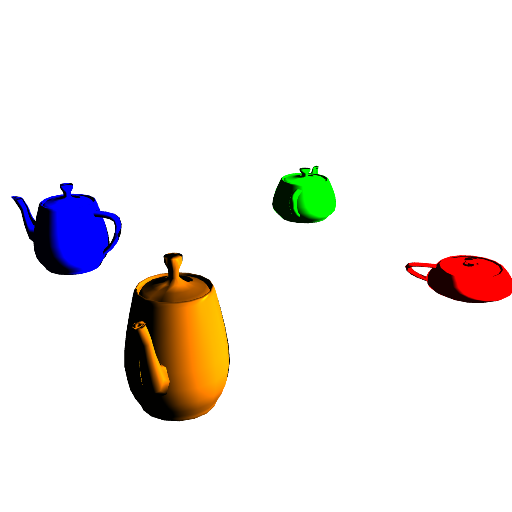

In [2]:
def main():

    anti_aliasing_table = np.array(
        [
            [-0.52, 0.38, 0.128],
            [0.41, 0.56, 0.119],
            [0.27, 0.08, 0.294],
            [-0.17, -0.29, 0.249],
            [0.58, -0.55, 0.104],
            [-0.31, -0.71, 0.106],
        ]
    )

    canvas = Canvas(
        "a6-scene.json",
        lighting_mode=LightingMode.PHONG,
        anti_aliasing_table=anti_aliasing_table,
    )
    display(canvas.im)


if __name__ == "__main__":
    main()


In [1]:
import json
import sys
from enum import Enum
from math import cos, radians, sin

import numpy as np
from PIL import Image


class Util:
    @staticmethod
    def normalize(x: np.ndarray):
        return x / np.linalg.norm(x)


class LightingMode(Enum):
    FLAT_SHADING = 0
    GOURAUD = 1
    PHONG = 2


class LightSource:
    def __init__(self, light_source_json):
        self.id = light_source_json["id"]
        self.type = light_source_json["type"]
        self.color = np.array(light_source_json["color"])
        self.intensity = light_source_json["intensity"]

        if self.type == "directional":
            self.light_source_from = np.array(light_source_json["from"])
            self.light_source_to = np.array(light_source_json["to"])

            self.v = self.light_source_from - self.light_source_to


class Camera:
    def __init__(self, camera_json: object):
        # Set bounds
        self.bounds = Bounds(camera_json["bounds"])

        # Set R, U, N, V values
        camera_from_json = camera_json["from"]
        camera_to_json = camera_json["to"]

        self.camera_from = np.array(camera_from_json)
        self.camera_to = np.array(camera_to_json)

        # R = Camera "location"
        self.r = self.camera_from - self.camera_to

        # N = Camera Z-Axis
        # Initially assumed to be = Normalized R
        self.n = Util.normalize(self.r)

        # U = Camera X-Axis
        # We are making the assumption that the camera's Y-axis is [0,1,0] to find X
        # Then to find the actual Y-Axis, we cross this X-axis value with the Z-axis value
        self.u = np.cross([0, 1, 0], self.n)

        # V = Camera Y-Axis
        # By finding the X-Axis above, can calculate the actual Y-axis
        self.v = np.cross(self.n, self.u)

        # Normalize
        self.u = Util.normalize(self.u)
        self.v = Util.normalize(self.v)

        # Compute the View and Perspective Projection Matrices
        self.__compute_view_matrix()
        self.__compute_perspective_projection_matrix()
        self.__compute_view_perspective_projection_composite_matrix()

    def __compute_view_matrix(self):
        self.view_matrix = np.array(
            [
                [
                    self.u[0],
                    self.u[1],
                    self.u[2],
                    -1 * np.dot(self.r, self.u),
                ],
                [
                    self.v[0],
                    self.v[1],
                    self.v[2],
                    -1 * np.dot(self.r, self.v),
                ],
                [
                    self.n[0],
                    self.n[1],
                    self.n[2],
                    -1 * np.dot(self.r, self.n),
                ],
                [0, 0, 0, 1],
            ]
        )

    def __compute_perspective_projection_matrix(self):
        self.perspective_projection_matrix = np.array(
            [
                [
                    2 * self.bounds.near / (self.bounds.right - self.bounds.left),
                    0,
                    (self.bounds.right + self.bounds.left)
                    / (self.bounds.right - self.bounds.left),
                    0,
                ],
                [
                    0,
                    (2 * self.bounds.near) / (self.bounds.top - self.bounds.bottom),
                    (self.bounds.top + self.bounds.bottom)
                    / (self.bounds.top - self.bounds.bottom),
                    0,
                ],
                [
                    0,
                    0,
                    -1
                    * (self.bounds.far + self.bounds.near)
                    / (self.bounds.far - self.bounds.near),
                    -1
                    * (2 * self.bounds.far * self.bounds.near)
                    / (self.bounds.far - self.bounds.near),
                ],
                [0, 0, -1, 0],
            ]
        )

    def __compute_view_perspective_projection_composite_matrix(self):
        self.view_perspective_projection_composite_matrix = np.dot(
            self.perspective_projection_matrix, self.view_matrix
        )


class Bounds:
    def __init__(self, bounds_json: object):
        self.near = bounds_json[0]
        self.far = bounds_json[1]
        self.right = bounds_json[2]
        self.left = bounds_json[3]
        self.top = bounds_json[4]
        self.bottom = bounds_json[5]


class Material:
    def __init__(self, material_json: object):
        self.Cs = np.array(material_json["Cs"])
        self.Ka = material_json["Ka"]
        self.Kd = material_json["Kd"]
        self.Ks = material_json["Ks"]
        self.n = material_json["n"]


class Transforms:
    def __init__(self, transforms_json):
        self.transforms = transforms_json
        self.__compute_transform_and_normal_transform_matrices()

    def __compute_transform_and_normal_transform_matrices(self):

        self.transforms_matrix = np.identity(4)
        self.normals_transforms_matrix = np.identity(4)

        for transform in self.transforms:
            (transform_key, transform_value) = next(iter(transform.items()))

            if transform_key == "Ry":
                self.transforms_matrix = np.dot(
                    [
                        [
                            cos(radians(transform_value)),
                            0,
                            sin(radians(transform_value)),
                            0,
                        ],
                        [0, 1, 0, 0],
                        [
                            -1 * sin(radians(transform_value)),
                            0,
                            cos(radians(transform_value)),
                            0,
                        ],
                        [0, 0, 0, 1],
                    ],
                    self.transforms_matrix,
                )

                # Same as transform matrix
                self.normals_transforms_matrix = np.dot(
                    [
                        [
                            cos(radians(transform_value)),
                            0,
                            sin(radians(transform_value)),
                            0,
                        ],
                        [0, 1, 0, 0],
                        [
                            -1 * sin(radians(transform_value)),
                            0,
                            cos(radians(transform_value)),
                            0,
                        ],
                        [0, 0, 0, 1],
                    ],
                    self.normals_transforms_matrix,
                )
            elif transform_key == "S":
                self.transforms_matrix = np.dot(
                    [
                        [transform_value[0], 0, 0, 0],
                        [0, transform_value[1], 0, 0],
                        [0, 0, transform_value[2], 0],
                        [0, 0, 0, 1],
                    ],
                    self.transforms_matrix,
                )

                # Inverse of transform matrix
                self.normals_transforms_matrix = np.dot(
                    [
                        [1 / transform_value[0], 0, 0, 0],
                        [0, 1 / transform_value[1], 0, 0],
                        [0, 0, 1 / transform_value[2], 0],
                        [0, 0, 0, 1],
                    ],
                    self.normals_transforms_matrix,
                )
            elif transform_key == "T":
                self.transforms_matrix = np.dot(
                    [
                        [1, 0, 0, transform_value[0]],
                        [0, 1, 0, transform_value[1]],
                        [0, 0, 1, transform_value[2]],
                        [0, 0, 0, 1],
                    ],
                    self.transforms_matrix,
                )

                # Normal matrix unaffected


class Vertex:
    def __init__(self, vertex_json):
        # Vertex coordinates
        # Append the homogeneous coordinate
        self.v = np.concatenate((vertex_json["v"], [1]), dtype=np.float64)

        # Vertex normals
        # self.n = np.array(vertex_json["n"], dtype=np.float64)
        self.n = np.concatenate((vertex_json["n"], [1]), dtype=np.float64)

        # Texture coordinate
        self.t = np.array(vertex_json["t"], dtype=np.float64)

        # Has color attribute, but only in Gouraud
        self.color = (0, 0, 0)


class Triangle:
    def __init__(self, triangle_json: object):
        self.vertices: list[Vertex] = []
        for _, vertex_json in triangle_json.items():
            self.vertices.append(Vertex(vertex_json))

    def x_min(self):
        return min(self.vertices, key=lambda vertex: vertex.v[0]).v[0]

    def x_max(self):
        return max(self.vertices, key=lambda vertex: vertex.v[0]).v[0]

    def y_min(self):
        return min(self.vertices, key=lambda vertex: vertex.v[1]).v[1]

    def y_max(self):
        return max(self.vertices, key=lambda vertex: vertex.v[1]).v[1]

    # For flat shading
    def compute_flat_shading_color(self):
        dot_p = np.dot([0.707, 0.5, 0.5], self.vertices[0].n[:3])

        if dot_p < 0:
            dot_p *= -1
        elif dot_p > 1.0:
            dot_p = 1.0

        self.color = (
            int(0.95 * dot_p * 255),
            int(0.65 * dot_p * 255),
            int(0.88 * dot_p * 255),
        )

        self.color = (255 * np.dot([0.95, 0.65, 0.88], dot_p)).astype(int)

    def f01(self, x: np.float64, y: np.float64):
        # f01(x,y) = (y0-y1)x + (x1-x0)y + x0y1-x1y0
        return (
            (self.vertices[0].v[1] - self.vertices[1].v[1]) * x
            + (self.vertices[1].v[0] - self.vertices[0].v[0]) * y
            + (self.vertices[0].v[0] * self.vertices[1].v[1])
            - (self.vertices[1].v[0] * self.vertices[0].v[1])
        )

    def f12(self, x: np.float64, y: np.float64):
        # f12(x,y) = (y1-y2)x + (x2-x1)y + x1y2-x2y1
        return (
            (self.vertices[1].v[1] - self.vertices[2].v[1]) * x
            + (self.vertices[2].v[0] - self.vertices[1].v[0]) * y
            + (self.vertices[1].v[0] * self.vertices[2].v[1])
            - (self.vertices[2].v[0] * self.vertices[1].v[1])
        )

    def f20(self, x: np.float64, y: np.float64):
        # f20(x,y) = (y2-y0)x + (x0-x2)y + x2y0-x0y2
        return (
            (self.vertices[2].v[1] - self.vertices[0].v[1]) * x
            + (self.vertices[0].v[0] - self.vertices[2].v[0]) * y
            + (self.vertices[2].v[0] * self.vertices[0].v[1])
            - (self.vertices[0].v[0] * self.vertices[2].v[1])
        )


class Shape:
    def __init__(self, shape_json: object):
        self.id = shape_json["id"]
        self.notes = shape_json["notes"]
        self.geometry = shape_json["geometry"]
        self.material = Material(shape_json["material"])
        self.transforms = Transforms(shape_json["transforms"])

        # Note: Load json files independently so avoid reference sharing
        shape_file = open(f"{self.geometry}.json")
        geometry_json = json.load(shape_file)

        self.triangles: list[Triangle] = []

        for triangle_json in geometry_json["data"]:
            self.triangles.append(Triangle(triangle_json))

        print(
            f"Loaded '{self.id}' from '{self.geometry}.json'. Notes: {self.notes if self.notes else '(none)'}."
        )


class Canvas:
    def __init__(
        self,
        scene_file_name: str,
        lighting_mode: LightingMode,
        anti_aliasing_table=np.ndarray,
    ):
        self.lighting_mode = lighting_mode
        self.anti_aliasing_table = anti_aliasing_table

        self.frame_buffers: list[np.ndarray()] = []

        # Create a new frame buffer for each anti_aliasing
        # -- This is to prevent accidental reference sharing
        for anti_aliasing_index, anti_aliasing_values in enumerate(
            self.anti_aliasing_table
        ):
            print(
                f"Scene file: '{scene_file_name}' at anti-aliasing index {anti_aliasing_index}"
            )

            scene_file = open(scene_file_name)
            scene_json = json.load(scene_file)["scene"]

            shapes_json = scene_json["shapes"]
            light_sources_json = scene_json["lights"]
            camera_json = scene_json["camera"]
            resolution_json = camera_json["resolution"]

            # Set camera (includes bounds)
            self.camera = Camera(camera_json)

            # Set resolution
            self.width: int = resolution_json[0]
            self.height: int = resolution_json[1]

            # Create new frame buffer at anti_aliasing_index
            # self.frame_buffers.append(
            #     [[0 for _ in range(self.width)] for _ in range(self.height)]
            # )

            # Initialize empty lights list
            self.light_sources: list[LightSource] = []
            for light_source_json in light_sources_json:
                self.light_sources.append(LightSource(light_source_json))

            # Initialize empty shapes list
            self.shapes: list[Shape] = []
            for shape_json in shapes_json:
                self.shapes.append(Shape(shape_json))

            # Create Pillow image
            self.im = Image.new("RGB", (self.width, self.height), color=(255, 255, 255))

            # Initialize Z-Buffer
            self.z_buffer: list[list[float]] = [
                [sys.float_info.max for _ in range(self.width)]
                for _ in range(self.height)
            ]

            # Anti-aliasing values
            anti_aliasing_dx = anti_aliasing_values[0] / (self.width - 1)
            anti_aliasing_dy = anti_aliasing_values[1] / (self.height - 1)
            # anti_aliasing_weight = anti_aliasing_values[2]

            # Draw the models at the end
            self.draw_models(anti_aliasing_dx, anti_aliasing_dy)

            # self.save(f"aa-render-{anti_aliasing_index}.png")
            self.frame_buffers.append(np.array(self.im))

        self.im = Image.new("RGB", (self.width, self.height), color=(255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):

                color = np.zeros(3)

                for frame_buffer_index, frame_buffer in enumerate(self.frame_buffers):
                    anti_aliasing_weight = anti_aliasing_table[frame_buffer_index][2]
                    color += anti_aliasing_weight * frame_buffer[y][x]

                self.im.putpixel((x, y), tuple(color.astype(int)))

        # self.save(f"aa-render-final.png")

    def show(self):
        self.im.show()

    def save(self, output_file_name="output.png"):
        self.im.save(output_file_name)

    def draw_models(self, anti_aliasing_dx: float, anti_aliasing_dy: float):
        # Transform Vertices
        for shape in self.shapes:
            for triangle in shape.triangles:
                for vertex in triangle.vertices:

                    # # Transform the shape in Object space
                    vertex.v = np.dot(shape.transforms.transforms_matrix, vertex.v)
                    vertex.n = np.dot(
                        shape.transforms.normals_transforms_matrix, vertex.n
                    )

                    # Transform Vertex from World Space to NDC Space
                    vertex.v = np.dot(
                        self.camera.view_perspective_projection_composite_matrix,
                        vertex.v,
                    )
                    vertex.v /= vertex.v[3]

                    # Apply anti-aliasing
                    vertex.v[0] += anti_aliasing_dx
                    vertex.v[1] += anti_aliasing_dy

                    # Normalize Vertex to Screen Space
                    vertex.v[0] = ((vertex.v[0] + 1) * (self.width - 1)) / 2
                    vertex.v[1] = ((1 - vertex.v[1]) * (self.height - 1)) / 2

                    if self.lighting_mode == LightingMode.GOURAUD:
                        color_specular = np.zeros(3)
                        color_diffuse = np.zeros(3)
                        color_ambient = np.zeros(3)

                        # N = Surface Normal Vector
                        N = vertex.n[:3]

                        # E = Eye ray direction
                        E = -1 * self.camera.n

                        for light_source in self.light_sources:
                            if light_source.type == "directional":
                                # L = Light ray direction
                                L = -1 * light_source.v

                                # R = Reflected ray
                                R = 2 * np.dot(N, L) * N - L
                                R = Util.normalize(R)

                                N_dot_L_sign = np.sign(np.dot(N, L))
                                N_dot_E_sign = np.sign(np.dot(N, E))

                                R_dot_E_clamped = np.clip(np.dot(R, E), 0, 1)

                                if N_dot_L_sign == 1 and N_dot_E_sign == 1:
                                    color_specular += light_source.color * np.power(
                                        R_dot_E_clamped, shape.material.n
                                    )
                                    color_diffuse += light_source.color * np.dot(N, L)

                                elif N_dot_L_sign == -1 and N_dot_E_sign == -1:
                                    color_specular += light_source.color * np.power(
                                        R_dot_E_clamped, shape.material.n
                                    )
                                    color_diffuse += light_source.color * np.dot(
                                        -1 * N, L
                                    )
                                else:
                                    pass

                            elif light_source.type == "ambient":
                                color_ambient += (
                                    light_source.color * light_source.intensity
                                )

                        vertex.color = (
                            255
                            * shape.material.Cs
                            * (
                                shape.material.Ks * color_specular
                                + shape.material.Kd * color_diffuse
                                + shape.material.Ka * color_ambient
                            )
                        ).astype(int)

                if self.lighting_mode == LightingMode.FLAT_SHADING:
                    triangle.compute_flat_shading_color()

                if self.lighting_mode == LightingMode.PHONG:
                    self.draw_triangle(triangle, shape.material)
                else:
                    self.draw_triangle(triangle)

    def draw_triangle(self, triangle: Triangle, material: Material = None):
        # If Phong shading, need to pass in material details for color calculation

        x_min = int(triangle.x_min())
        x_max = int(triangle.x_max())
        y_min = int(triangle.y_min())
        y_max = int(triangle.y_max())

        for y in range(max(0, y_min), min(self.height, y_max + 1)):
            for x in range(max(0, x_min), min(self.width, x_max + 1)):
                alpha = triangle.f12(x, y) / triangle.f12(
                    triangle.vertices[0].v[0], triangle.vertices[0].v[1]
                )
                beta = triangle.f20(x, y) / triangle.f20(
                    triangle.vertices[1].v[0], triangle.vertices[1].v[1]
                )
                gamma = triangle.f01(x, y) / triangle.f01(
                    triangle.vertices[2].v[0], triangle.vertices[2].v[1]
                )

                if alpha >= 0 and beta >= 0 and gamma >= 0:
                    z = (
                        alpha * triangle.vertices[0].v[2]
                        + beta * triangle.vertices[1].v[2]
                        + gamma * triangle.vertices[2].v[2]
                    )

                    if z < self.z_buffer[y][x]:

                        color = (0, 0, 0)

                        if self.lighting_mode == LightingMode.FLAT_SHADING:
                            color = triangle.color
                        elif self.lighting_mode == LightingMode.GOURAUD:
                            color = (
                                alpha * triangle.vertices[0].color
                                + beta * triangle.vertices[1].color
                                + gamma * triangle.vertices[2].color
                            ).astype(int)
                        elif self.lighting_mode == LightingMode.PHONG:
                            color_specular = np.zeros(3)
                            color_diffuse = np.zeros(3)
                            color_ambient = np.zeros(3)

                            # N = Interpolated Surface Normal Vector
                            N = (
                                alpha * triangle.vertices[0].n[:3]
                                + beta * triangle.vertices[1].n[:3]
                                + gamma * triangle.vertices[2].n[:3]
                            )

                            # E = Eye ray direction
                            E = -1 * self.camera.n

                            for light_source in self.light_sources:
                                if light_source.type == "directional":
                                    # L = Light ray direction
                                    L = -1 * light_source.v

                                    # R = Reflected ray
                                    R = 2 * np.dot(N, L) * N - L
                                    R = Util.normalize(R)

                                    N_dot_L_sign = np.sign(np.dot(N, L))
                                    N_dot_E_sign = np.sign(np.dot(N, E))

                                    R_dot_E_clamped = np.clip(np.dot(R, E), 0, 1)

                                    if N_dot_L_sign == 1 and N_dot_E_sign == 1:
                                        color_specular += light_source.color * np.power(
                                            R_dot_E_clamped, material.n
                                        )
                                        color_diffuse += light_source.color * np.dot(
                                            N, L
                                        )

                                    elif N_dot_L_sign == -1 and N_dot_E_sign == -1:
                                        color_specular += light_source.color * np.power(
                                            R_dot_E_clamped, material.n
                                        )
                                        color_diffuse += light_source.color * np.dot(
                                            -1 * N, L
                                        )
                                    else:
                                        pass

                                elif light_source.type == "ambient":
                                    color_ambient += (
                                        light_source.color * light_source.intensity
                                    )

                            color = (
                                255
                                * material.Cs
                                * (
                                    material.Ks * color_specular
                                    + material.Kd * color_diffuse
                                    + material.Ka * color_ambient
                                )
                            ).astype(int)

                        color = np.clip(color, 0, 255)

                        self.im.putpixel((x, y), tuple(color))
                        self.z_buffer[y][x] = z
